In [70]:
import os
import numpy as np
import random
import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
import lsst.afw.display as afwDisplay

from astropy.table import Table
from astropy.visualization import ZScaleInterval

In [71]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (6, 6)
zscale = ZScaleInterval()

In [72]:
def cutout_coadd_ra_dec(butler, ra, dec, filter='r', datasetType='deepCoadd', **kwargs):
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    return cutout_coadd_spherepoint(butler, radec, filter=filter, datasetType=datasetType)

def cutout_coadd_spherepoint(butler, radec, filter='r', datasetType='deepCoadd',
                             skymap=None, cutoutSideLength=200, **kwargs):
    cutoutSize = afwGeom.ExtentI(cutoutSideLength, cutoutSideLength)
    if skymap is None:
        skymap = butler.get("%s_skyMap" % datasetType)
     # Look up the tract, patch for the RA, Dec
    tractInfo = skymap.findTract(radec)
    patchInfo = tractInfo.findPatch(radec)
    xy = afwGeom.PointI(tractInfo.getWcs().skyToPixel(radec))
    bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)
    coaddId = {'tract': tractInfo.getId(), 'patch': "%d,%d" % patchInfo.getIndex(), 'filter': filter}
    cutout_image = butler.get(datasetType+'_sub', bbox=bbox, immediate=True, dataId=coaddId)
    return cutout_image

In [73]:
def make_cutout_image(butler, ra, dec, filter='r', vmin=None, vmax=None, label=None,
                      show=True, saveplot=False, savefits=False,
                      datasetType='deepCoadd'):
    cutout_image = cutout_coadd_ra_dec(butler, ra, dec, filter=filter, datasetType='deepCoadd')
    if savefits:
        if isinstance(savefits, str):
            filename = savefits
        else:
            filename = 'postage-stamp.fits'
        cutout_image.writeFits(filename)
    
    radec = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)
    xy = cutout_image.getWcs().skyToPixel(radec)
    
    if vmin is None or vmax is None:
        vmin, vmax = zscale.get_limits(cutout_image.image.array)

    plt.imshow(cutout_image.image.array, vmin=vmin, vmax=vmax, cmap='binary_r', origin='lower')
    plt.colorbar()
    plt.scatter(xy.getX() - cutout_image.getX0(), xy.getY() - cutout_image.getY0(),
                color='none', edgecolor='red', marker='o', s=200)
    if label is not None:
        plt.title(label)
    if saveplot:
        if isinstance(saveplot, str):
            filename = saveplot
        else:
            filename = 'postage-stamp.png'
        plt.savefig(filename)
    if show:
        plt.show()

    return cutout_image

In [74]:
%store -r bright_objects_filtered_idx01
%store -r bright_objects_filtered_ra01
%store -r bright_objects_filtered_dec01

%store -r bright_objects_filtered_idx11
%store -r bright_objects_filtered_ra11
%store -r bright_objects_filtered_dec11

In [75]:
bright_objects_filtered_idx01 = np.array(bright_objects_filtered_idx01).tolist()
bright_objects_filtered_ra01 = np.array(bright_objects_filtered_ra01).tolist()
bright_objects_filtered_dec01 = np.array(bright_objects_filtered_dec01).tolist()

bright_objects_filtered_idx11 = np.array(bright_objects_filtered_idx11).tolist()
bright_objects_filtered_ra11 = np.array(bright_objects_filtered_ra11).tolist()
bright_objects_filtered_dec11 = np.array(bright_objects_filtered_dec11).tolist()

In [76]:
repo = '/global/projecta/projectdirs/lsst/global/in2p3/Run1.1/output'
butler = dafPersist.Butler(repo)

In [77]:
bright_objects_table01 = Table([bright_objects_filtered_idx01,
                              bright_objects_filtered_ra01,
                              bright_objects_filtered_dec01], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})

bright_objects_table11 = Table([bright_objects_filtered_idx11,
                              bright_objects_filtered_ra11,
                              bright_objects_filtered_dec11], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table11'})

In [78]:
subfolder = 'Stamps'
if not os.path.exists(subfolder):
    os.mkdir(subfolder)

In [79]:
random_bright_table11 = Table([[0], [float(0)], [float(0)]], names=('ID', 'RA', 'DEC'), 
                              meta={'name' : 'bright_objects_table01'})
count = 0
while count < 5:
    row = random.choice(bright_objects_table11)
    random_bright_table11.add_row(row)
    count+=1
random_bright_table11.remove_row(0)
print(random_bright_table11)

   ID         RA           DEC      
------- ------------- --------------
5313226 52.9083257478 -28.2130138938
4344351 57.8748685639 -28.5245159977
4640420 56.9687652532 -29.1110952093
4679381 57.1913252054 -28.5853047805
4751196 56.8384132021  -29.010778682


In [84]:
save_table = random_bright_table11

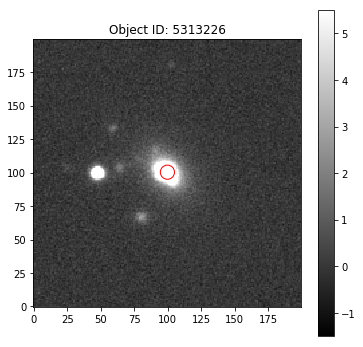

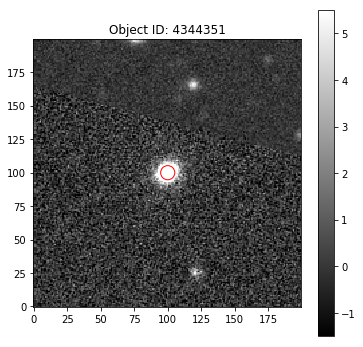

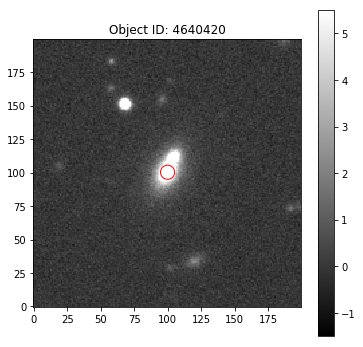

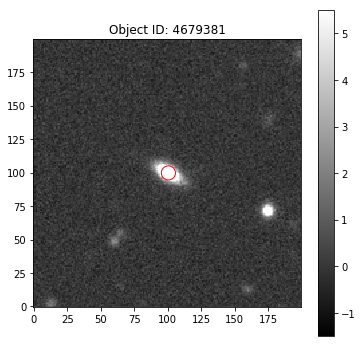

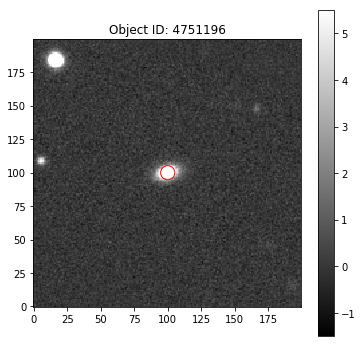

In [85]:
frame = 5
vmin, vmax = -1.5, +5.5
filter = 'i'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in save_table:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)

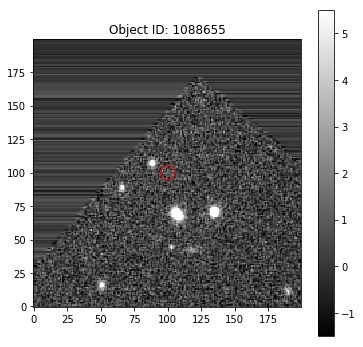

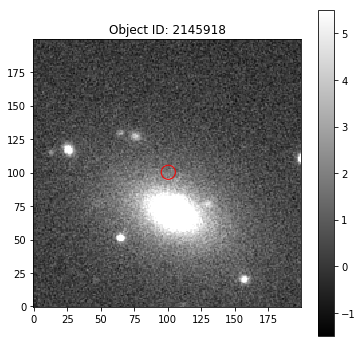

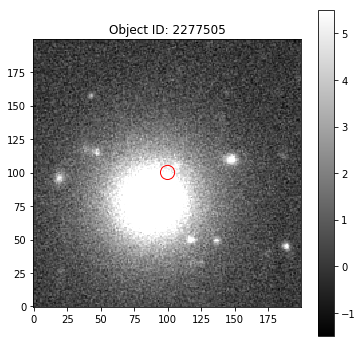

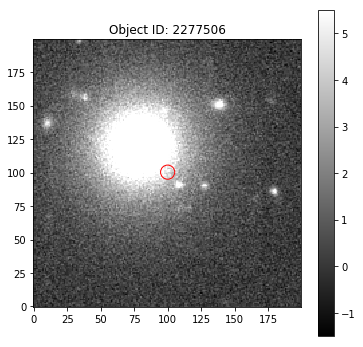

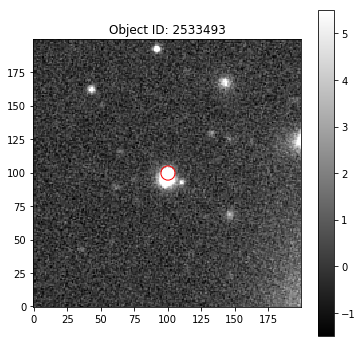

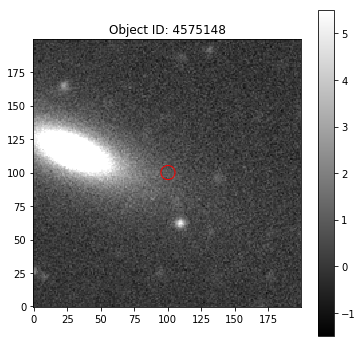

In [83]:
frame = 5
vmin, vmax = -1.5, +5.5
filter = 'i'
show = True
saveplot = False
datasetType = 'deepCoadd'

for objectId, ra, dec in bright_objects_table01:
    plt.figure(frame)
    plt.clf()
    basename = "Stamps/%s_%s_%s" % (datasetType, objectId, filter)
    saveplot = "%s.png" % basename
    cutout = make_cutout_image(butler, ra, dec, filter=filter, vmin=vmin, vmax=vmax,
                      label="Object ID: %d" % objectId,
                      show=show, saveplot=saveplot)